# Restuarant Vistors Time Series Analysis
The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

In [3]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [4]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [5]:
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [7]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


### Plot the source data

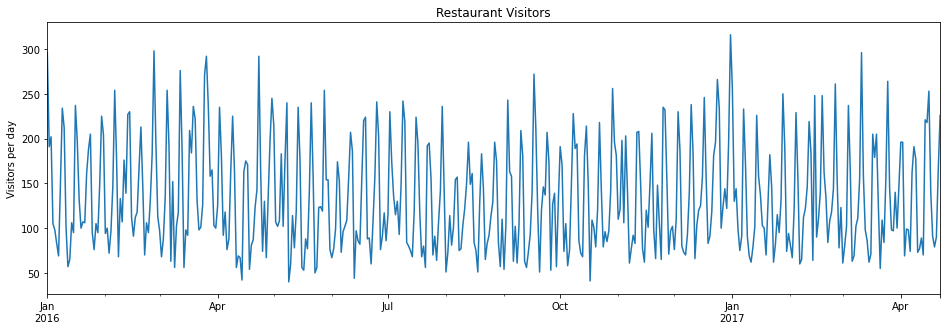

In [8]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## To Point Out Holidays
Use matplotlib to plot the holidays during the time series duration.

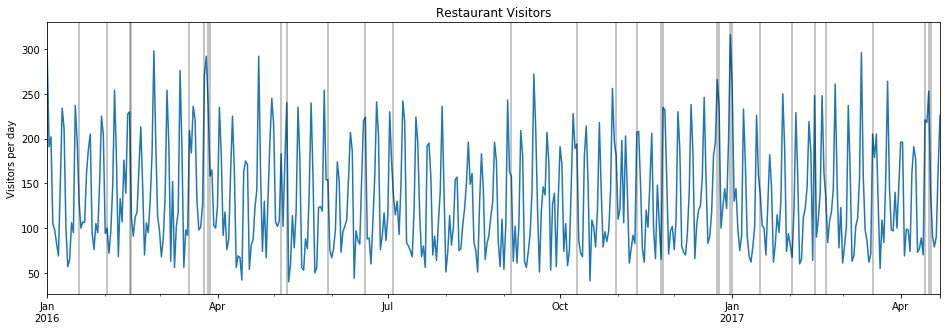

In [7]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

### Run an ETS Decomposition

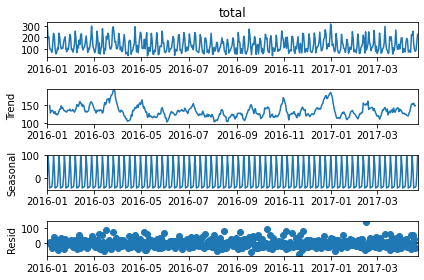

In [9]:
result = seasonal_decompose(df1['total'])
result.plot();

<AxesSubplot:xlabel='date'>

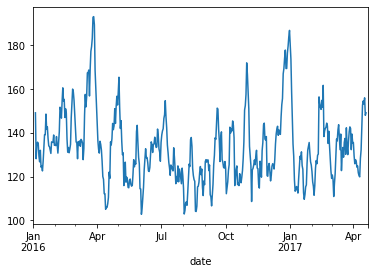

In [39]:
result.trend.plot()

<AxesSubplot:xlabel='date'>

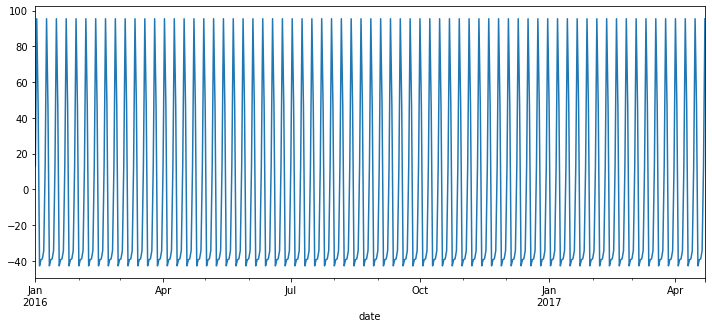

In [44]:
result.seasonal.plot(figsize=(12,5))

<AxesSubplot:xlabel='date'>

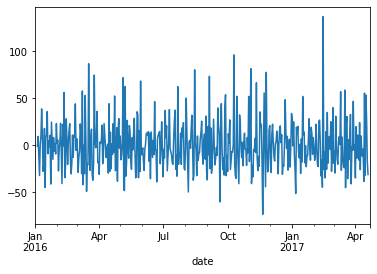

In [42]:
result.resid.plot()

## Dickey_Fuller test for stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders


In [15]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],max_p=10,max_q=10,max_d=10,max_D=10,max_P=10,max_Q=10,seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(3, 0, 0, 7)   Log Likelihood               -2401.086
Date:                           Tue, 27 Jun 2023   AIC                           4814.173
Time:                                   17:34:32   BIC                           4839.190
Sample:                               01-01-2016   HQIC                          4824.008
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.0018      4.129      4.117      0.000       8.909      25.095
ar.L1          0.1862      0.046      4.082      0.000       0.097       0.276
ar.S.L7        0.3182      0.043      7.427      0.000       0.234       0.402
ar.S.L14       0.2749      0.043      6.379      0.000       0.190       0.359
ar.S.L21       0.2483      0.044      5.702      0.000       0.163       0.334
sigma2      1352.5862     82.367     16.421      0.000    1191.149    1514.023
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                42.23
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.58
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (1,0,0) and a seasonal order of (3,0,0,7) Now  train & test the SARIMA model, evaluate it, then compare the result to a model that uses an exogenous variable.
### Split the data into train/test sets
Assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [13]:
len(df1)

478

In [16]:
# Set 6 weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### Fit a SARIMA(1,0,0)(3,0,0,7) Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [20]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(3,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(3, 0, 0, 7)   Log Likelihood               -2202.796
Date:                           Tue, 27 Jun 2023   AIC                           4415.593
Time:                                   17:38:39   BIC                           4435.981
Sample:                               01-01-2016   HQIC                          4423.639
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2264      0.047      4.863      0.000       0.135       0.318
ar.S.L7        0.3550      0.044      7.994      0.000       0.268       0.442
ar.S.L14       0.2998      0.045      6.645      0.000       0.211       0.388
ar.S.L21       0.3203      0.043      7.411      0.000       0.236       0.405
sigma2      1368.0049     71.738     19.070      0.000    1227.402    1508.608
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                47.40
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.48
Prob(H) (two-sided):                  0.88   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(3,0,0,7) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).


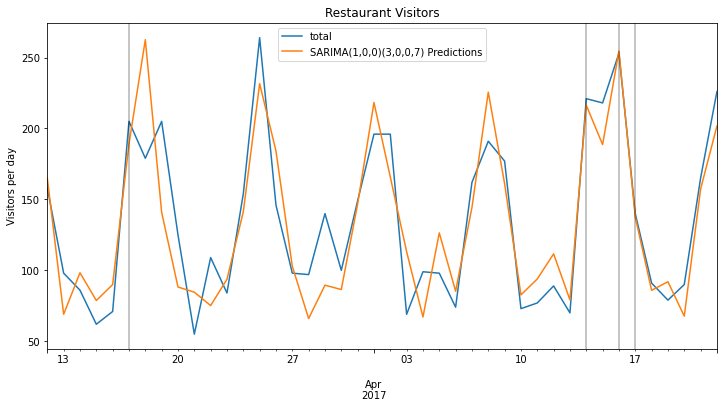

In [47]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

### Evaluate the Model

In [48]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(3,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(3,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(3,0,0,7) MSE Error: 788.9928512
SARIMA(1,0,0)(3,0,0,7) RMSE Error: 28.08901656


## Now to check the affect of  the exog variable (SARIMAX).

In [50]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(3,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(3, 0, 0, 7)   Log Likelihood               -2139.800
Date:                           Tue, 27 Jun 2023   AIC                           4291.600
Time:                                   19:44:33   BIC                           4316.066
Sample:                               01-01-2016   HQIC                          4301.256
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       58.7912      4.470     13.153      0.000      50.030      67.552
ar.L1          0.2468      0.048      5.151      0.000       0.153       0.341
ar.S.L7        0.3639      0.052      6.976      0.000       0.262       0.466
ar.S.L14       0.2624      0.055      4.789      0.000       0.155       0.370
ar.S.L21       0.3565      0.048      7.469      0.000       0.263       0.450
sigma2      1101.4482     73.156     15.056      0.000     958.064    1244.832
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                 7.94
Prob(Q):                              0.30   Prob(JB):                         0.02
Heteroskedasticity (H):               1.14   Skew:                             0.10
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(3,0,0,7) Predictions')

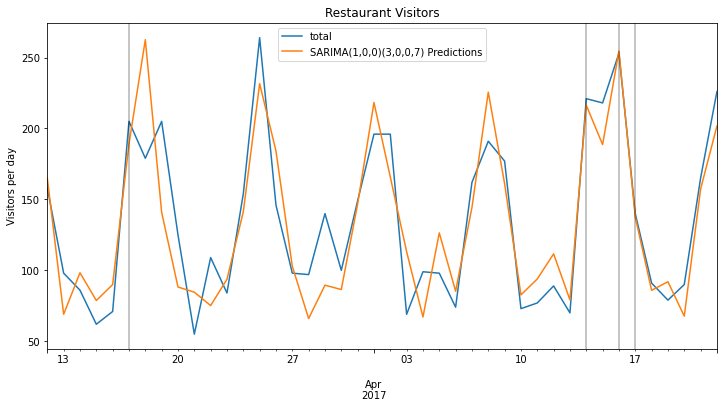

In [49]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at 3/17, 4/14, 4/16 and 4/17! Let's compare evaluations:
### Evaluate the Model

In [36]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(3,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(3,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(3,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(3,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(3,0,0,7) MSE Error: 1019.163954
SARIMA(1,0,0)(3,0,0,7) RMSE Error: 31.92434735

SARIMAX(1,0,0)(3,0,0,7) MSE Error: 788.9928512
SARIMAX(1,0,0)(3,0,0,7) RMSE Error: 28.08901656


### Retrain the model on the full data, and forecast the future
We're going to forecast 39 days into the future, and use the additional holiday data

In [37]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(3,0,0,7) Forecast')

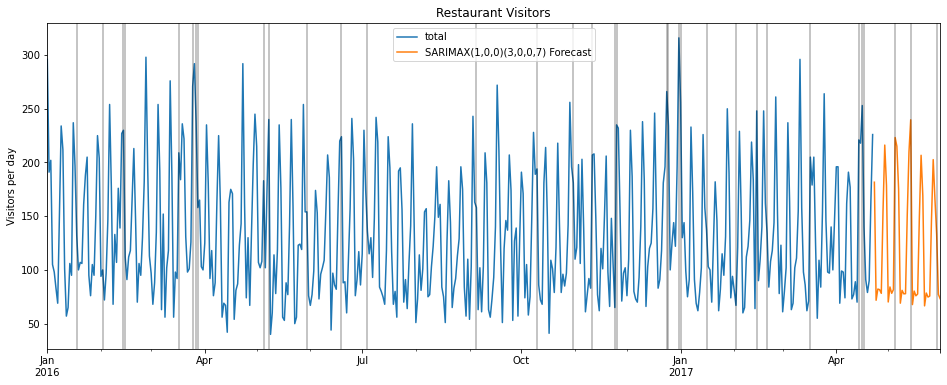

In [38]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);